**For your information, here are some specs of T4.**

https://images.nvidia.com/aem-dam/en-zz/Solutions/design-visualization/technologies/turing-architecture/NVIDIA-Turing-Architecture-Whitepaper.pdf

* Number of SMs: 40
* CUDA Cores/SM: 64
* Tensor Cores/SM: 8
* L1 cache (cache for each SM): 64KB
* L2 shared cache: 6MB
* Memory: 16GB

In [2]:
import time
import torch
import triton
import triton.language as tl
import numpy as np
import torch.nn as nn
import triton.testing as tt_test
import os
from typing import List, Union, Dict

In [3]:
def verify_output(
    actual: Union[np.ndarray, List[np.ndarray]],
    reference: Union[np.ndarray, List[np.ndarray]],
    name: Union[str, List[str]],
    atol: float = 1e-5,
    rtol: float = 1e-5
) -> None:
  """
  Verify if the actual output is close to the reference output.

  Args:
    actual: The actual output.
    reference: The reference output.
    atol: The absolute tolerance.
    rtol: The relative tolerance.
  """
  if isinstance(actual, np.ndarray):
    close = np.allclose(actual, reference, atol=atol, rtol=rtol)
    if not close:
      print(f"{name} is not close to the reference output.")
    else:
      print(f"{name} is close to the reference output.")
  elif isinstance(actual, List):
    close = all(verify_output(a, b, name[i], atol=atol, rtol=rtol)
                for i, (a, b) in enumerate(zip(actual, reference)))
  return close

For the next two questions, you need pycuda to run this.

In [ ]:
!pip install pycuda # pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 18.0 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=f3fa823156545f83b2f33c8739c390bab8aa2242224b542fe335706dcbc670a9
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


In [ ]:
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray

# Problem A. ReLU using CUDA



Let us implement 1D ReLU in CUDA.

First, we need to write a kernel function.

Hint: CUDA has a function fmaxf to calculate the maximum value of float32.

In [ ]:
# CUDA kernel to merge multiple operations
kernel_code = """
#include <cuda_runtime.h>

__global__ void relu_op(float *a, int length) {
  //  Compute the index of array from threadIdx and blockIdx.
  int idx = blockIdx.x * blockDim.x + threadIdx.x;

  // Make sure it is not out of boundary
  if (idx < length) {
    // -------------------
    // Your code goes here
    // -------------------
    a[idx] = fmaxf(0.0f, a[idx]);
  }
}
"""

mod = SourceModule(kernel_code)
relu_kernel = mod.get_function("relu_op")

Next, let us launch the training job.

Please fill in the block size an grid size.

In [ ]:
def relu_using_cuda(x: torch.Tensor) -> torch.Tensor:
  nlen = x.shape[0]
  x_np = x.numpy()
  x_pycuda = cuda.InOut(x_np)

  #########################
  ## Your code goes here
  #########################
  block_size = (32, 1, 1)
  grid_size = (4, 1)

  relu_kernel(x_pycuda, np.int32(nlen),
              block=block_size, grid=grid_size)
  return torch.Tensor(x_np)

At last, let us test it. Do not change the code below.

In [ ]:
# Accuracy test

print('#### Accuracy test ####')
x = torch.randn(100, dtype=torch.float32)
relu_layer = nn.ReLU()
result_torch = relu_layer(x)
result_cuda = relu_using_cuda(x)
verify_output(result_torch.numpy(), result_cuda, 'ReLU')

#### Accuracy test ####
ReLU is close to the reference output.


True

# Problem B. 2D minus using CUDA



Next, try C = B - A, but for 2D matrix.

Kernel function



In [ ]:
# CUDA kernel to merge multiple operations
kernel_code = """
#include <cuda_runtime.h>

// CUDA kernel for c = a - b
__global__ void minus_op(float *a, float *b, float *c, int height, int width) {
  // Compute the index of array from threadIdx and blockIdx.
  int x = blockIdx.x * blockDim.x + threadIdx.x;
  int y = blockIdx.y * blockDim.y + threadIdx.y;
  int idx = y * width + x;
  // -------------------
  // Your code goes here
  // -------------------
  if (x < width && y < height) {
    c[idx] = a[idx] - b[idx];
  }
}
"""

mod = SourceModule(kernel_code)
minus_kernel = mod.get_function("minus_op")

Launch kernel

In [ ]:
def minus_using_internal(a: cuda.In,
                         b: cuda.In,
                         c: cuda.Out,
                         height: int,
                         width: int):
  #########################
  ## Your code goes here
  #########################
  block_dim = 16
  block_size = (block_dim, block_dim, 1)
  grid_size = ((width + block_dim - 1) // block_dim,
               (height + block_dim - 1)// block_dim)
  minus_kernel(a, b, c,
               np.int32(height), np.int32(width),
               block=block_size, grid=grid_size)

def minus_using_cuda(a: torch.Tensor,
                     b: torch.Tensor) -> torch.Tensor:
  height, width = a.shape[0], a.shape[1]
  a_np, b_np = a.numpy(), b.numpy()
  c_np = np.zeros_like(a)
  a_pycuda, b_pycuda, c_pycuda = cuda.In(a_np), cuda.In(b_np), cuda.Out(c_np)
  minus_using_internal(a_pycuda, b_pycuda, c_pycuda, height, width)
  return torch.Tensor(c_np)

At last, let us test it. We also include a speed test.

Do not change the code below. You mush test on T4.

In [ ]:
x = torch.randn((100, 100), dtype=torch.float32)
y = torch.randn((100, 100), dtype=torch.float32)
result_cuda = minus_using_cuda(x, y)

In [ ]:
# Accuracy test
print('#### Accuracy test ####')
x = torch.randn((100, 100), dtype=torch.float32)
y = torch.randn((100, 100), dtype=torch.float32)
result_torch = x - y
result_cuda = minus_using_cuda(x, y)
verify_output(result_torch.numpy(), result_cuda, 'Minus')

## Speed test
print()
print('#### Speed test ####')
height = 5000
width = 5000
a = torch.randn((height, width), dtype=torch.float32)
b = torch.randn((height, width), dtype=torch.float32)
c = np.zeros_like(a)
a_pycuda, b_pycuda, c_pycuda = cuda.In(a.numpy()), cuda.In(b.numpy()), cuda.Out(c)

t0 = time.time()
target_latency = 90
latency = tt_test.do_bench(
    lambda: minus_using_internal(a_pycuda, b_pycuda, c_pycuda, height, width))
print(f'The latency of this op is {latency}')
if latency < target_latency:
  print(f'This is faster than the target latency, {target_latency} ms. Pass!')
else:
  print(f'This is slower than the target latency, {target_latency} ms. Fail...')

#### Accuracy test ####
Minus is close to the reference output.

#### Speed test ####
The latency of this op is 64.42221069335938
This is faster than the target latency, 90 ms. Pass!


# Problem C. 2D minus using Triton



Starting from this question, let us switch to Triton, which is more like Pytorch programming. First, let us redo 2D minus, but using Triton this time.

Similar to CUDA, we first need to define the Triton kernel.

In [ ]:
@triton.jit
def minus_triton_kernel(
  # Pointers to the two input matrices A and B, and the output matrix C
  A, B, C,
  # Dimensions of the matrices
  rows, cols,
  # Meta-parameters (constants passed to the JIT compiler)
  BLOCK_SIZE_ROW: tl.constexpr,
  BLOCK_SIZE_COL: tl.constexpr
):
  # 1. Get the 2D ID of the block indice
  pid_row = tl.program_id(axis=0)
  pid_col = tl.program_id(axis=1)

  # 2. Calculate the row and column indices for the current block
  off_row = (pid_row * BLOCK_SIZE_ROW) + tl.arange(0, BLOCK_SIZE_ROW)
  off_col = (pid_col * BLOCK_SIZE_COL) + tl.arange(0, BLOCK_SIZE_COL)
  off = off_row[:, None] * cols + off_col[None, :]

  # 3. Create masks to handle boundary conditions.
  mask_row = off_row < rows
  mask_col = off_col < cols
  mask = mask_row[:, None] & mask_col[None, :]

  # 4. Load the data from A and B into the shared memory.
  a = tl.load(A + off, mask=mask)
  b = tl.load(B + off, mask=mask)

  # 5. Perform the computation.
  c = a - b

  # 6. Store the result back to C.
  tl.store(C + off, c, mask=mask)

And also launch it.

In [ ]:
def minus_using_triton(a: torch.Tensor,
                       b: torch.Tensor) -> torch.Tensor:
  rows, cols = a.shape
  c = torch.empty_like(a)
  # print(rows, cols)
  # Block size is the power of 2 greater than the number of columns in X
  # Multiply by 2 to load both the x row and the y column
  #########################
  ## Your code goes here
  #########################
  # Switch to this when release to students.
  BLOCK_SIZE_COL = 32
  BLOCK_SIZE_ROW = 32
  grid = (32, 32)

  minus_triton_kernel[grid](
      a, b, c, rows, cols,
      BLOCK_SIZE_ROW=BLOCK_SIZE_ROW, BLOCK_SIZE_COL=BLOCK_SIZE_COL
  )
  return c

And let us test the speed and accuracy. Do not change it.

(Server side speed test is not super stable, so it is o.k. to run multiple times)

In [ ]:
# Accuracy test

print('#### Accuracy test ####')
x = torch.randn((100, 100), device='cuda:0', dtype=torch.float32)
y = torch.randn((100, 100), device='cuda:0', dtype=torch.float32)
result_torch = x - y
result_cuda = minus_using_triton(x, y)
verify_output(result_torch.cpu().numpy(), result_cuda.cpu().numpy(), 'Minus')

## Speed test
print()
print('#### Speed test ####')
height = 5000
width = 5000
x = torch.randn((height, width), device='cuda:0', dtype=torch.float32)
y = torch.randn((height, width), device='cuda:0', dtype=torch.float32)

target_latency = 2.1
latency = tt_test.do_bench(lambda: minus_using_triton(x, y))

print(f'The latency of this op is {latency} ms')
if latency < target_latency:
  print(f'This is faster than the target latency, {target_latency} ms. Pass!')
else:
  print(f'This is slower than the target latency, {target_latency} ms. Fail...')

#### Accuracy test ####
Minus is close to the reference output.

#### Speed test ####
The latency of this op is 0.07129440046846866 ms
This is faster than the target latency, 2.1 ms. Pass!


Have some trouble to find a good config? You can also try the triton.autotune. No need to run the one below, but you can try it.

In [ ]:
import os

os.environ['TRITON_PRINT_AUTOTUNING'] = '1'

# Define a tunable kernel
@triton.autotune(
    configs=[
        # Test configurations with various block sizes (M x N)
        triton.Config({'BLOCK_SIZE_ROW': 16, 'BLOCK_SIZE_COL': 16}),
        triton.Config({'BLOCK_SIZE_ROW': 32, 'BLOCK_SIZE_COL': 32}),
        triton.Config({'BLOCK_SIZE_ROW': 64, 'BLOCK_SIZE_COL': 64}),
        triton.Config({'BLOCK_SIZE_ROW': 128, 'BLOCK_SIZE_COL': 128}),
        triton.Config({'BLOCK_SIZE_ROW': 256, 'BLOCK_SIZE_COL': 16}),
        triton.Config({'BLOCK_SIZE_ROW': 16, 'BLOCK_SIZE_COL': 256}),
    ],
    # The 'key' determines when Triton caches a previously tuned result.
    key=['rows', 'cols'],
)
@triton.jit
def minus_triton_kernel2(
  # Pointers to the two input matrices A and B, and the output matrix C
  A, B, C,
  # Dimensions of the matrices
  rows, cols,
  # Meta-parameters (constants passed to the JIT compiler)
  BLOCK_SIZE_ROW: tl.constexpr,
  BLOCK_SIZE_COL: tl.constexpr
):
  # 1. Get the 2D ID of the block indice
  pid_row = tl.program_id(axis=0)
  pid_col = tl.program_id(axis=1)

  # 2. Calculate the row and column indices for the current block
  off_row = (pid_row * BLOCK_SIZE_ROW) + tl.arange(0, BLOCK_SIZE_ROW)
  off_col = (pid_col * BLOCK_SIZE_COL) + tl.arange(0, BLOCK_SIZE_COL)
  off = off_row[:, None] * cols + off_col[None, :]

  # 3. Create masks to handle boundary conditions.
  mask_row = off_row < rows
  mask_col = off_col < cols
  mask = mask_row[:, None] & mask_col[None, :]

  # 4. Load the data from A and B into the shared memory.
  a = tl.load(A + off, mask=mask)
  b = tl.load(B + off, mask=mask)

  # 5. Perform the computation.
  c = a - b

  # 6. Store the result back to C.
  tl.store(C + off, c, mask=mask)

# Issue kernels
def minus_using_triton2(a: torch.Tensor,
                       b: torch.Tensor) -> torch.Tensor:
  rows, cols = a.shape
  c = torch.empty_like(a)

  # Block size is the power of 2 greater than the number of columns in X
  # Multiply by 2 to load both the x row and the y column
  BLOCK_SIZE = 32

  # Create a 2-D grid to iterate across rows and columns
  grid = lambda meta: (triton.cdiv(rows, meta['BLOCK_SIZE_ROW']),
                       triton.cdiv(cols, meta['BLOCK_SIZE_COL']))
  minus_triton_kernel2[grid](
      a, b, c, rows, cols
  )
  return c

# Run testing
minus_triton_kernel2.cache_results = True
height = 5000
width = 5000
x = torch.randn((height, width), device='cuda:0', dtype=torch.float32)
y = torch.randn((height, width), device='cuda:0', dtype=torch.float32)
z = minus_using_triton2(x, y)

Autotuning kernel minus_triton_kernel2 with config BLOCK_SIZE_ROW: 16, BLOCK_SIZE_COL: 16, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel minus_triton_kernel2 with config BLOCK_SIZE_ROW: 32, BLOCK_SIZE_COL: 32, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel minus_triton_kernel2 with config BLOCK_SIZE_ROW: 64, BLOCK_SIZE_COL: 64, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel minus_triton_kernel2 with config BLOCK_SIZE_ROW: 128, BLOCK_SIZE_COL: 128, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel minus_triton_kernel2 with config BLOCK_SIZE_ROW: 256, BLOCK_SIZE_COL: 16, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Autotuning kernel minus_triton_kernel2 with config BLOCK_SIZE_ROW: 16, BLOCK_SIZE_COL: 256, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
Triton autotuning for function minus_triton_kernel2,
with key as (5000, 5000, 'torch.float32', 'torch.float32', 't

# Problem D. Matmul (Triton, simple)



Next, let us try to implement 2D matrix multiplication.

Recall that the matrix multiplication is defined as:

c = a @ b

which is calculated as:

c[i, k] = sum_j a[i, j] * b[j, k]

For your reference, here is a reference implementation in python.

In [ ]:
def matmul_numpy(a: np.ndarray, b: np.ndarray) -> np.ndarray:
  """
  Matrix multiplication reference implementation.

  Args:
    a: numpy array of shape (M, N)
    b: numpy array of shape (N, K)
  Returns:
    c: numpy array of shape (M, K)
  """
  if a.ndim != 2 or b.ndim != 2:
    raise ValueError("Input matrices must be 2D")
  if a.shape[1] != b.shape[0]:
    raise ValueError("Number of columns in A must match number of rows in B")

  M, N = a.shape
  _, K = b.shape
  c = np.zeros((M, K))

  for i in range(M):
    for j in range(K):
      c[i, j] = np.sum(a[i, :] * b[:, j])

  return c

a = np.random.rand(3, 4)
b = np.random.rand(4, 5)
_ = verify_output(matmul_numpy(a, b), a @ b, 'matmul')

matmul is close to the reference output.


Let us implement in Triton. For this problem, we will use a very simple version (a better version will be implemented in Problem E).

For each block send to SM, we will calculate the block of output c[m:m+Bm, k:k+Bk]. To calculate that, we need to first load a[m:m+Bm, :] and b[k:, k+Bk].

Note that matrix are stored in row-major in memroy, so that a[m:m+Bm, :] will be in continuous block, but b will not. This will significantly slows down the processing. Therefore, we can first transpose b, and grab bt[k:, k+Bk] instead.

An illustration of this solution is shown below.

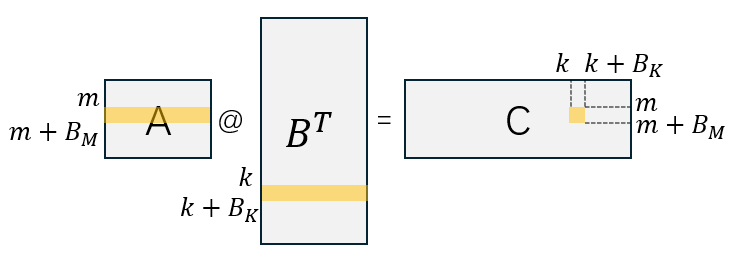

In [ ]:
@triton.jit
def matmul_triton_kernel(
  A, B, C,
  M, N, K,
  BLOCK_SIZE_M: tl.constexpr,
  BLOCK_SIZE_N: tl.constexpr,
  BLOCK_SIZE_K: tl.constexpr
):
  """
  Matrix multiplication Triton kernel.

  Args:
    A: Tensor of shape (M, N)
    B: Tensor of shape (N, K)
    C: Tensor of shape (M, K)
    M: number of rows in A
    N: number of columns in A and rows in B
    K: number of columns in B
  """
  # 1. Get the 2D ID of the block indice
  pid_m = tl.program_id(axis=0)
  pid_k = tl.program_id(axis=1)

  # 2. Calculate the row and column indices for the current block
  # We load just a block of data along M and K dimension
  off_m = (pid_m * BLOCK_SIZE_M) + tl.arange(0, BLOCK_SIZE_M)
  off_n = tl.arange(0, BLOCK_SIZE_N)
  # But load entire block along N dimension
  off_k = (pid_k * BLOCK_SIZE_K) + tl.arange(0, BLOCK_SIZE_K)
  # Based on this, calculate the offset of three blocks shown in the yellow
  # block above.
  off_a = off_m[:, None] * N + off_n[None, :]
  off_b = off_n[:, None] * K + off_k[None, :]
  off_c = off_m[:, None] * K + off_k[None, :]

  # 3. Create masks to handle boundary conditions.
  #########################
  ## Your code goes here
  #########################
  mask_m = off_m < M
  mask_k = off_k < K
  mask_n = off_n < N
  mask_a = mask_m[:, None] & mask_n[None, :]
  mask_b = mask_n[:, None] & mask_k[None, :]
  mask_c = mask_m[:, None] & mask_k[None, :]

  # 4. Load the data from A and B into the shared memory.
  a = tl.load(A + off_a, mask=mask_a)
  b = tl.load(B + off_b, mask=mask_b)

  # 5. Perform the computation.
  # Calculate the matrix multiple of a and b.
  # Hint: using tl.sum. It behaves similar to torch.sum.
  #########################
  ## Your code goes here
  #########################
  c = tl.sum(a[:, :, None] * b[None, :, :], axis=1)

  # 6. Store the result back to C.
  tl.store(C + off_c, c, mask=mask_c) # this stores the result back to C.


def matmul_triton(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
  """
  Matrix multiplication using triton.

  Args:
    a: Tensor of shape (M, N)
    b: Tensor of shape (N, K)
  Returns:
    c: Tensor of shape (M, K)
  """
  if a.ndim != 2 or b.ndim != 2:
    raise ValueError("Input matrices must be 2D")
  if a.shape[1] != b.shape[0]:
    raise ValueError("Number of columns in A must match number of rows in B")

  M, N = a.shape
  _, K = b.shape
  # Output tensor
  BLOCK_SIZE_N = triton.next_power_of_2(N)
  c = torch.empty((M, K), device=a.device, dtype=a.dtype)
  # BLOCK_SIZE_N = 256
  #########################
  ## Your code goes here
  #########################
  # Switch to this when release to students.
  BLOCK_SIZE_M = 4
  BLOCK_SIZE_K = 32
  grid = ((M + BLOCK_SIZE_M - 1) // BLOCK_SIZE_M,
        (K + BLOCK_SIZE_K - 1) // BLOCK_SIZE_K)
  matmul_triton_kernel[grid](
      a, b, c, M, N, K,
      BLOCK_SIZE_M=BLOCK_SIZE_M, BLOCK_SIZE_N=BLOCK_SIZE_N,
      BLOCK_SIZE_K=BLOCK_SIZE_K)
  return c

And let us test the speed and accuracy. Do not change it. It may take about a minute to run.

In [ ]:
# Accuracy test

print('#### Accuracy test ####')
for M, N, K, tol in [(1, 3, 2, 1e-5),
                     (2, 3, 5, 1e-5),
                     (20, 30, 50, 1e-4),
                     (200, 300, 500, 1e-4)]:
  x = torch.randn((M, N), device='cuda:0', dtype=torch.float32)
  y = torch.randn((N, K), device='cuda:0', dtype=torch.float32)
  result_torch = x @ y
  result_triton = matmul_triton(x, y)
  verify_output(result_torch.cpu().numpy(), result_triton.cpu().numpy(),
                f'Matmal on {M}x{N} x {N}x{K}', atol=tol, rtol=tol)

#### Accuracy test ####
Matmal on 1x3 x 3x2 is close to the reference output.
Matmal on 2x3 x 3x5 is close to the reference output.
Matmal on 20x30 x 30x50 is close to the reference output.
Matmal on 200x300 x 300x500 is close to the reference output.


In [ ]:
# Speed test
print('#### Speed test ####')
M = 400
N = 512
K = 800
x = torch.randn((M, N), device='cuda:0', dtype=torch.float32)
y = torch.randn((N, K), device='cuda:0', dtype=torch.float32)

target_latency = 1.3
latency = tt_test.do_bench(
    lambda: matmul_triton(x, y), warmup=5, rep=10)

print(f'The latency of this op is {latency} ms')
if latency < target_latency:
  print(f'This is faster than the target latency, {target_latency} ms. \033[92mPass\033[0m!')
else:
  print(f'This is slower than the target latency, {target_latency} ms. \033[91mFail\033[0m ...')

#### Speed test ####
The latency of this op is 0.849263995885849 ms
This is faster than the target latency, 1.3 ms. Pass!


Moreover, please

1. Plot latency of this op when setting the BLOCK_SIZE_M and BLOCK_SIZE_K to 2, 4, 8, 16, 32 (assuming BLOCK_SIZE_M==BLOCK_SIZE_K). You may need to change the triton function to support
2. Calculate (roughly) the memory usage of **EACH BLOCK** when choose different block size. Compare that with L1 cache of T4, do you see any interesting conclusion? Why?

Hint: for the memory usage, just calculate what is memory consumption of this two loading functions and one saving functions:
```
a = tl.load(A + off_a, mask=mask_a)
b = tl.load(B + off_b, mask=mask_b)
tl.store(C + off_c, c, mask=mask_c)
```

In [ ]:
#######################
### Your code goes here
#######################
@triton.jit
def matmul_triton_kernel(
  A, B, C,
  M, N, K,
  BLOCK_SIZE_M: tl.constexpr,
  BLOCK_SIZE_N: tl.constexpr,
  BLOCK_SIZE_K: tl.constexpr
):
  """
  Matrix multiplication Triton kernel.

  Args:
    A: Tensor of shape (M, N)
    B: Tensor of shape (N, K)
    C: Tensor of shape (M, K)
    M: number of rows in A
    N: number of columns in A and rows in B
    K: number of columns in B
  """
  # 1. Get the 2D ID of the block indice
  pid_m = tl.program_id(axis=0)
  pid_k = tl.program_id(axis=1)

  # 2. Calculate the row and column indices for the current block
  # We load just a block of data along M and K dimension
  off_m = (pid_m * BLOCK_SIZE_M) + tl.arange(0, BLOCK_SIZE_M)
  off_n = tl.arange(0, BLOCK_SIZE_N)
  # But load entire block along N dimension
  off_k = (pid_k * BLOCK_SIZE_K) + tl.arange(0, BLOCK_SIZE_K)
  # Based on this, calculate the offset of three blocks shown in the yellow
  # block above.
  off_a = off_m[:, None] * N + off_n[None, :]
  off_b = off_n[:, None] * K + off_k[None, :]
  off_c = off_m[:, None] * K + off_k[None, :]

  # 3. Create masks to handle boundary conditions.
  #########################
  ## Your code goes here
  #########################
  mask_m = off_m < M
  mask_k = off_k < K
  mask_n = off_n < N
  mask_a = mask_m[:, None] & mask_n[None, :]
  mask_b = mask_n[:, None] & mask_k[None, :]
  mask_c = mask_m[:, None] & mask_k[None, :]

  # 4. Load the data from A and B into the shared memory.
  a = tl.load(A + off_a, mask=mask_a)
  b = tl.load(B + off_b, mask=mask_b)

  # 5. Perform the computation.
  # Calculate the matrix multiple of a and b.
  # Hint: using tl.sum. It behaves similar to torch.sum.
  #########################
  ## Your code goes here
  #########################
  c = tl.sum(a[:, :, None] * b[None, :, :], axis=1)

  # 6. Store the result back to C.
  tl.store(C + off_c, c, mask=mask_c) # this stores the result back to C.


def matmul_triton(a: torch.Tensor, b: torch.Tensor
                  , block_size: int) -> torch.Tensor:
  """
  Matrix multiplication using triton.

  Args:
    a: Tensor of shape (M, N)
    b: Tensor of shape (N, K)
  Returns:
    c: Tensor of shape (M, K)
  """
  if a.ndim != 2 or b.ndim != 2:
    raise ValueError("Input matrices must be 2D")
  if a.shape[1] != b.shape[0]:
    raise ValueError("Number of columns in A must match number of rows in B")

  M, N = a.shape
  _, K = b.shape
  # Output tensor
  BLOCK_SIZE_N = triton.next_power_of_2(N)
  c = torch.empty((M, K), device=a.device, dtype=a.dtype)
  BLOCK_SIZE_N = 256
  #########################
  ## Your code goes here
  #########################
  # Switch to this when release to students.
  BLOCK_SIZE_M = block_size
  BLOCK_SIZE_K = block_size
  grid = ((M + BLOCK_SIZE_M - 1) // BLOCK_SIZE_M,
        (K + BLOCK_SIZE_K - 1) // BLOCK_SIZE_K)
  matmul_triton_kernel[grid](
      a, b, c, M, N, K,
      BLOCK_SIZE_M=BLOCK_SIZE_M, BLOCK_SIZE_N=BLOCK_SIZE_N,
      BLOCK_SIZE_K=BLOCK_SIZE_K)
  return c

block_size = [2, 4, 8, 16, 32]
print('#### Speed test ####')
M = 400
N = 512
K = 800
x = torch.randn((M, N), device='cuda:0', dtype=torch.float32)
y = torch.randn((N, K), device='cuda:0', dtype=torch.float32)
latency = []
mem_usage_list = []
for i in block_size:
  latency_num = tt_test.do_bench(
    lambda: matmul_triton(x, y, i), warmup=5, rep=10)
  latency.append(latency_num)
  dtype_bytes = 4
  a_memory = i * 256 * dtype_bytes
  b_memory = 256 * i * dtype_bytes
  c_memory = i * i * dtype_bytes
  total_memory = a_memory + b_memory + c_memory
  total_memory_kb = total_memory / 1024
  mem_usage_list.append(total_memory_kb)

T4_L1_CACHE_SIZE_KB = 64
opt_block_size = block_size[np.argmin(latency)]
mem_usage = mem_usage_list[np.argmin(latency)]
print(f'the opt block size is {opt_block_size}')
print(f'the memory usage is {mem_usage} KB')
print(f"T4 L1 Cache Size: {T4_L1_CACHE_SIZE_KB} KB")
print(f"Key Observations: The higher the use_of_memory/cache_size, programe runs faster")

#### Speed test ####
the opt block size is 16
the memory usage is 33.0 KB
T4 L1 Cache Size: 64 KB
Key Observations: The higher the use_of_memory/cache_size, programe runs faster


When chosing the optimal block_size as 16, the memory usage is 33.0


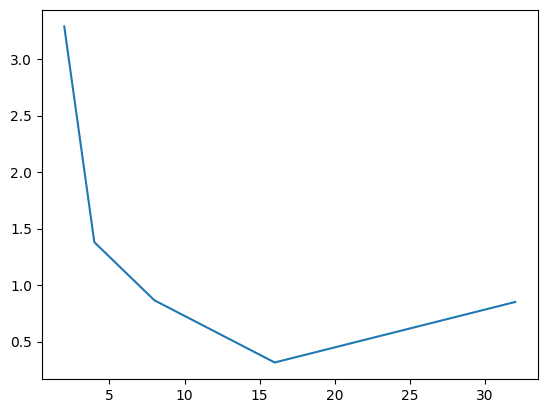

In [ ]:
# Once finished, run this block
import matplotlib.pyplot as plt
plt.plot(block_size, latency)
print(f'When chosing the optimal block_size as {opt_block_size}, '
      f'the memory usage is {mem_usage}')

At last, let us try an extreme case to show the limit of this approach. Choose N to be 100x larger, but M and be N be 10x smaller. In theory, this should have the same computational complex (note the time complexity of matrix mal is O(MNK)).

Try to tune your block size and see if you can make it similar latency as the previous one?

If not, think about why.

In [ ]:
print('#### Speed test ####')
M = 400 // 10
N = 512 * 100
K = 800 // 10
x = torch.randn((M, N), device='cuda:0', dtype=torch.float32)
y = torch.randn((N, K), device='cuda:0', dtype=torch.float32)

latency = tt_test.do_bench(
    lambda: matmul_triton(x, y), warmup=5, rep=10)
print(f'The latency of this op is {latency} ms')

#### Speed test ####
The latency of this op is 0.02165600028820336 ms


# Problem E. Matmul (Triton, Large matrix)

The previous example shows the limitation of our simple implementation: when N is large, the memory of each block may exceed L1 cache, making it inefficient.

Let us if we can make it more efficient. This time, we also chop along N dimention, for both A and B. Note in this time, the output is not a simply a multiple of these two blocks, but need sum all blocks along N dimenions, as shown below.

(Here we did not need to transpose B. Why?)

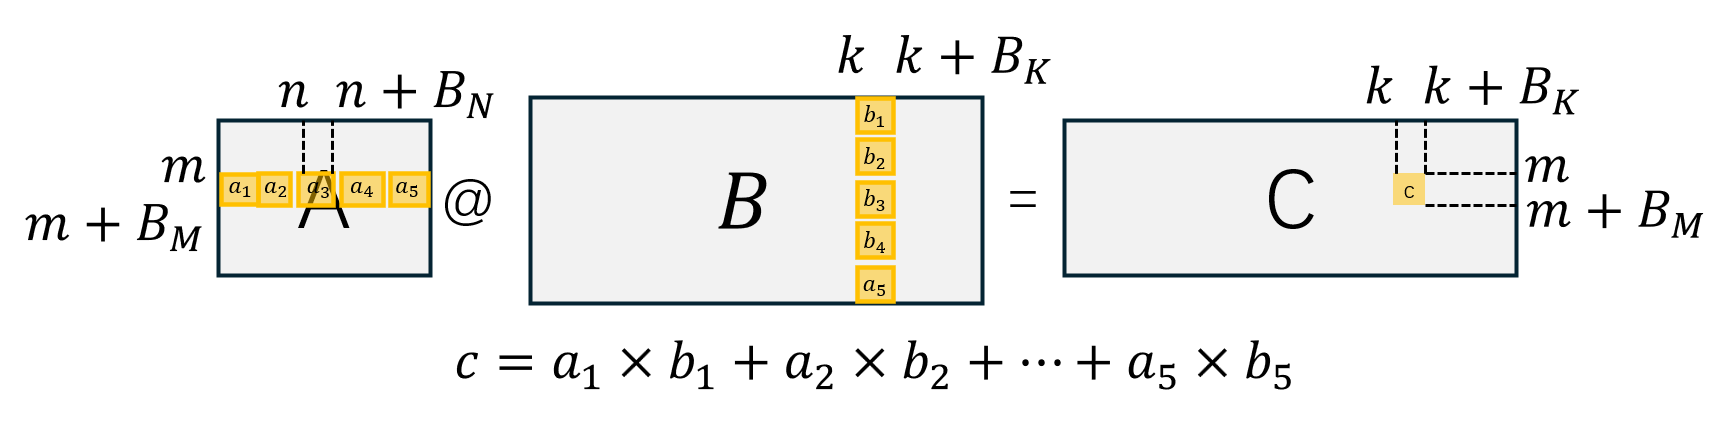

Please implement this one.

In [ ]:
@triton.jit
def fast_matmul_triton_kernel(
  A, B, C,
  M, N, K,
  BLOCK_SIZE_M: tl.constexpr,
  BLOCK_SIZE_N: tl.constexpr,
  BLOCK_SIZE_K: tl.constexpr
):
  """
  Matrix multiplication Triton kernel.

  Args:
    A: Tensor of shape (M, N)
    B: Tensor of shape (N, K)
    C: Tensor of shape (M, K)
    M: number of rows in A
    N: number of columns in A and rows in B
    K: number of columns in B
  """
  # 1. Get the 2D ID of the block indice
  pid_m = tl.program_id(axis=0)
  pid_k = tl.program_id(axis=1)

  # Create an empty block to store the accumulation of c
  acc_c = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_K), dtype=tl.float32)

  # Delete following four lines when releasing
  off_m = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
  off_k = pid_k * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K)
  mask_m = off_m < M
  mask_k = off_k < K

  for n in range(0, tl.cdiv(N, BLOCK_SIZE_N)):
    # 2. Calculate the row and column indices for the current block
    #########################
    ## Your code goes here
    #########################
    # off_a = ?
    # off_b = ?
    # off_c = ?
    off_n = n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    off_a = off_m[:, None] * N + off_n[None, :]
    off_b = off_n[:, None] * K + off_k[None, :]

    # 3. Create masks to handle boundary conditions.
    #########################
    ## Your code goes here
    #########################
    mask_n = off_n < N
    mask_a = mask_m[:, None] & mask_n[None, :]
    mask_b = mask_n[:, None] & mask_k[None, :]

    # 4. Load the data from A and B into the shared memory.
    a = tl.load(A + off_a, mask=mask_a)
    b = tl.load(B + off_b, mask=mask_b)

    # 5. Perform the computation.
    # Calculate the matrix multiple of a and b.
    # Hint: using tl.sum. It behaves similar to torch.sum.
    #########################
    ## Your code goes here
    #########################
    acc_c += tl.dot(a, b)

  # 6. Store the result back to C.
  #########################
  ## Your code goes here
  #########################
  # this stores the result back to C.
  off_c = off_m[:, None] * K + off_k[None, :]
  mask_c = mask_m[:, None] & mask_k[None, :]
  tl.store(C + off_c, acc_c, mask=mask_c)

def fast_matmul_triton(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
  """
  Matrix multiplication using triton.

  Args:
    a: Tensor of shape (M, N)
    b: Tensor of shape (N, K)
  Returns:
    c: Tensor of shape (M, K)
  """
  if a.ndim != 2 or b.ndim != 2:
    raise ValueError("Input matrices must be 2D")
  if a.shape[1] != b.shape[0]:
    raise ValueError("Number of columns in A must match number of rows in B")

  M, N = a.shape
  _, K = b.shape
  # Output tensor
  c = torch.empty((M, K), device=a.device, dtype=a.dtype)

  #########################
  ## Your code goes here
  #########################
  # Switch to this when release to students.
  BLOCK_SIZE_M = 16
  BLOCK_SIZE_N = 256
  BLOCK_SIZE_K = 16
  grid = ((M + BLOCK_SIZE_M - 1) // BLOCK_SIZE_M,
      (K + BLOCK_SIZE_K - 1) // BLOCK_SIZE_K)
  fast_matmul_triton_kernel[grid](
      a, b, c, M, N, K,
      BLOCK_SIZE_M=BLOCK_SIZE_M, BLOCK_SIZE_N=BLOCK_SIZE_N,
      BLOCK_SIZE_K=BLOCK_SIZE_K)
  return c

And let us test its accuracy first.

In [ ]:
# Accuracy test

print('#### Accuracy test ####')
for M, N, K, tol in [(1, 3, 2, 1e-5),
                     (2, 3, 5, 1e-5),
                     (20, 30, 50, 1e-4),
                     (200, 300, 500, 1e-4)]:
  x = torch.randn((M, N), device='cuda:0', dtype=torch.float32)
  y = torch.randn((N, K), device='cuda:0', dtype=torch.float32)
  result_torch = x @ y
  result_triton = fast_matmul_triton(x, y)
  verify_output(result_torch.cpu().numpy(), result_triton.cpu().numpy(),
                f'Matmal on {M}x{N} x {N}x{K}', atol=tol, rtol=tol)

#### Accuracy test ####
Matmal on 1x3 x 3x2 is close to the reference output.
Matmal on 2x3 x 3x5 is close to the reference output.
Matmal on 20x30 x 30x50 is close to the reference output.
Matmal on 200x300 x 300x500 is close to the reference output.


Also, check if we can run on the big matrix now more efficiently.

In [ ]:
# Speed test
print('#### Speed test ####')
M = 400 // 10
N = 512 * 100
K = 800 // 10
x = torch.randn((M, N), device='cuda:0', dtype=torch.float32)
y = torch.randn((N, K), device='cuda:0', dtype=torch.float32)

target_latency = 1.8
latency = tt_test.do_bench(
    lambda: fast_matmul_triton(x, y), warmup=5, rep=10)

print(f'The latency of this op is {latency} ms')
if latency < target_latency:
  print(f'This is faster than the target latency, {target_latency} ms. Pass!')
else:
  print(f'This is slower than the target latency, {target_latency} ms. Fail...')

#### Speed test ####
The latency of this op is 1.6210026741027832 ms
This is faster than the target latency, 1.8 ms. Pass!


# Problem F. Flash linear attention

At last, let us extent the problem E to linear attention version of flash attention

(For simplicity, let us only work on linear attention, and ignore the annoying softmax)

Note that linear attention is calculate as:
output = (Q * K^T) * V. Here is a reference implementation.

To make your life easy, here we assume:
* K, Q, V shared the same feature dimension
* K, Q, V has the same sequence length

In [4]:
def linear_attention(K: torch.tensor,
                     Q: torch.tensor,
                     V: torch.tensor) -> torch.tensor:
  """
  Linear attention implementation.
  Args:
    K: Tensor of shape (seq_len, feat_dim)
    Q: Tensor of shape (seq_len, feat_dim)
    V: Tensor of shape (seq_len, feat_dim)

  Returns:
    Tensor of shape (seq_len, feat_dim)
  """
  weight = Q @ torch.permute(K, (1, 0))
  return weight @ V

Similar to Problem E, we need to chop in both feature dimension and sequence dimension.

In Problem E, we only multiple two matrices A, B.

In this one, we need to slice three matrics, Q, K, and V. All three matrics have the same dimensions.
* For each block we sliced, we will load entire feature dimension, but only load part of seq dimension.
* For seq dimension of Q matrix, we slice them in to multiple blocks, each with size

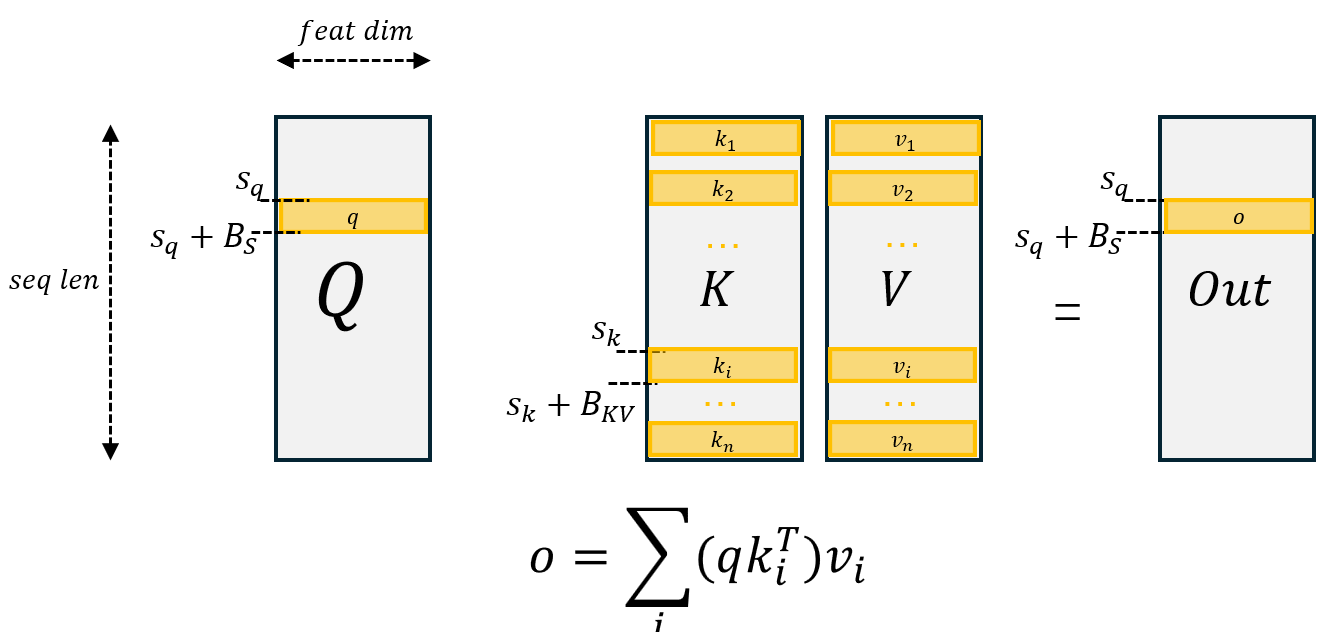

And write your implementation.

Hint:
* We would suggest to use the flashAttention2 schedule (similar to Problem E): the outer loop iterates over different Q block and inner loop iterate different KV blocks. In another word, the grid size should be equal to the number of Q blocks, and with kernel function, loops through KV blocks.

Ref:
https://tridao.me/publications/flash2/flash2.pdf Algorithm 2

In [6]:
#########################
## Your code goes here
#########################

@triton.jit
def linear_flash_attention_triton_kernel(
  K, Q, V, Out,
  dim, seq_len,
  BLOCK_SIZE_Q: tl.constexpr,
  BLOCK_SIZE_KV: tl.constexpr,
  BLOCK_SIZE_FEAT: tl.constexpr,
):
  """
  Flash attention Triton kernel.

  Args:
    K: Tensor of shape (seq_len, dim)
    Q: Tensor of shape (seq_len, dim)
    V: Tensor of shape (seq_len, dim)
    Out: Tensor of shape (seq_len, dim)
    dim: number of dimensions
    seq_len: number of sequence length
    BLOCK_SIZE_Q: number of feature block size when chopping Q matrix.
    BLOCK_SIZE_KV: number of feature block size when chopping K and V matrices.
    BLOCK_SIZE_FEAT: number of sequence length block size. This should be larger
      than the actual feature dimension.
  """
  pid_q = tl.program_id(0)
  off = tl.arange(0, BLOCK_SIZE_Q)
  mask = off < dim
  off_q = Q + pid_q * dim

  mask_feat = tl.arange(0, BLOCK_SIZE_FEAT) < dim
  q_block = tl.load(off_q + off, mask=mask)
  o = tl.zeros((BLOCK_SIZE_FEAT,), dtype=tl.float32)

  for pid_kv in range(seq_len):
    off_k = K + pid_kv * dim
    off_v = V + pid_kv * dim
    k_block = tl.load(off_k + off, mask=mask)
    v_block = tl.load(off_v + off, mask=mask)

    s = tl.sum(q_block * k_block)
    o += s * v_block

  off_out = Out + pid_q * dim
  tl.store(off_out + off, o, mask=mask)

def linear_flash_attention(K: torch.Tensor,
                           Q: torch.Tensor,
                           V: torch.Tensor) -> torch.Tensor:
  """
  Linear flash attention using triton.

  Args:
    K: Tensor of shape (seq_len, dim)
    Q: Tensor of shape (seq_len, dim)
    V: Tensor of shape (seq_len, dim)

  Returns:
    Out: Tensor of shape (seq_len, dim)
  """
  if K.ndim != 2 or Q.ndim != 2 or V.ndim != 2:
    raise ValueError("Input matrices must be 2D")
  if K.shape != V.shape != Q.shape:
    raise ValueError("Q, K, and V should have the same dimensions")

  seq_len, dim = Q.shape

  out = torch.empty((seq_len, dim), device=K.device, dtype=K.dtype)

  #########################
  ## Your code goes here
  #########################
  # Switch to this when release to students.
  BLOCK_SIZE_Q = 512
  BLOCK_SIZE_KV = 512
  BLOCK_SIZE_FEAT = 512

  grid = (seq_len,)
  linear_flash_attention_triton_kernel[grid](
      K, Q, V, out, dim, seq_len,
      BLOCK_SIZE_Q=BLOCK_SIZE_Q,
      BLOCK_SIZE_KV=BLOCK_SIZE_KV,
      BLOCK_SIZE_FEAT=BLOCK_SIZE_FEAT
  )
  return out


In [7]:
# Accuracy test
print('#### Accuracy test ####')
for seq_len, dim, tol in [(2, 3, 1e-5),
                          (20, 30, 1e-4),
                          (200, 300, 3e-4)]:
  K = torch.randn((seq_len, dim), device='cuda:0', dtype=torch.float32)
  Q = torch.randn((seq_len, dim), device='cuda:0', dtype=torch.float32)
  V = torch.randn((seq_len, dim), device='cuda:0', dtype=torch.float32)
  result_ref = linear_attention(K, Q, V)
  result_triton = linear_flash_attention(K, Q, V)
  verify_output(result_ref.cpu().numpy(), result_triton.cpu().numpy(),
                f'Attention with seq={seq_len} and feat={dim}',
                atol=tol, rtol=tol)

#### Accuracy test ####
Attention with seq=2 and feat=3 is close to the reference output.
Attention with seq=20 and feat=30 is close to the reference output.
Attention with seq=200 and feat=300 is close to the reference output.


In [9]:
# Speed test

print('#### Speed test ####')
for seq_len, feat_dim, target_latency in [(4000, 1000, 150),
                                          (400, 1000, 1.5),]:
  K = torch.randn((seq_len, feat_dim), device='cuda:0', dtype=torch.float32)
  Q = torch.randn((seq_len, feat_dim), device='cuda:0', dtype=torch.float32)
  V = torch.randn((seq_len, feat_dim), device='cuda:0', dtype=torch.float32)
  latency = tt_test.do_bench(
      lambda: linear_flash_attention(K, Q, V), warmup=5, rep=10)

  print(f'The latency of this op is {latency} ms')
  if latency < target_latency:
    print(f'This is faster than the target latency, {target_latency} ms. Pass!')
  else:
    print(f'This is slower than the target latency, {target_latency} ms. Fail...')

#### Speed test ####
The latency of this op is 102.795166015625 ms
This is faster than the target latency, 150 ms. Pass!
The latency of this op is 1.127528041601181 ms
This is faster than the target latency, 1.5 ms. Pass!


In [ ]:
# 1. Get the 2D ID of the block indice
pid_seq_q = tl.program_id(axis=0)
pid_feat = tl.program_id(axis=1)
# Create an empty block to store the accumulation of c
acc_out = tl.zeros((BLOCK_SIZE_Q, BLOCK_SIZE_FEAT), dtype=tl.float32)
# Delete this when releasing
off_seq_q = pid_seq_q * BLOCK_SIZE_Q + tl.arange(0, BLOCK_SIZE_Q)
off_feat = tl.arange(0, BLOCK_SIZE_FEAT)
mask_seq_q = off_seq_q < seq_len
mask_feat = off_feat < dim
off_q = off_seq_q[:,None] * dim + off_feat[None, :]
mask_q = mask_seq_q[:,None] & mask_feat[None, :]
q = tl.load(Q + off_q, mask=mask_q)
for idx_seq_kv in range(0, tl.cdiv(seq_len, BLOCK_SIZE_KV)):
# 2. Calculate the row and column indices for the current block
    off_seq_kv = idx_seq_kv * BLOCK_SIZE_KV + tl.arange(0, BLOCK_SIZE_KV)
    off_kv = off_seq_kv[:,None] * dim + off_feat[None, :]
    # 3. Create masks to handle boundary conditions.
    mask_seq_kv = off_seq_kv < seq_len
    mask_feat = off_feat < dim
    mask_kv = mask_seq_kv[:,None] & mask_feat[None, :]
    # 4. Load the data from A and B into the shared memory.
    k = tl.load(K + off_kv, mask=mask_kv)
    v = tl.load(V + off_kv, mask=mask_kv)
    # 5. Perform the computation.
    w = tl.sum(q[:,None, :] * k[None, :, :], axis=2, keep_dims=False)
    acc_out = acc_out + tl.sum(w[:, :,None] * v[None, :, :], axis=1, keep_dims=False)
# 6. Store the result back to C.
tl.store(Out + off_q, acc_out, mask=mask_q)
# this stores the result back to C.